In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import norm

## M-H sampling

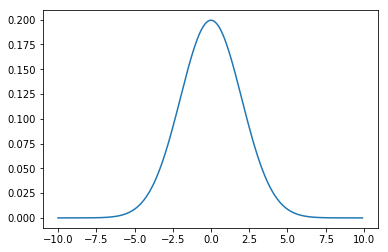

In [2]:
raw = np.arange(-10,10, 0.1)

global_mean = 0;
global_sigma = 2;

plt.plot(raw, norm.pdf(raw, global_mean, global_sigma))
# following is the distribution that we want to simulate

### step 1 choose a transformation matrix Q as we like

here we use a norm as the Q transformation, i.e

$P(x^{t+1}|x^t) = norm(x^t, 1).pdf(x^{t+1})$

In [3]:
## example 
xt = 3
xt_next = norm.rvs(loc = xt, scale = 1, size = 1 )
xt_next[0]

4.137294916484262

### step 2 choose a initialize state/distribution

In [4]:
## we can use only one dimension x to demo. we satrt from 0;
## the index of state represents T
state = []
state.append(0)

### step 3 do the M-H sample

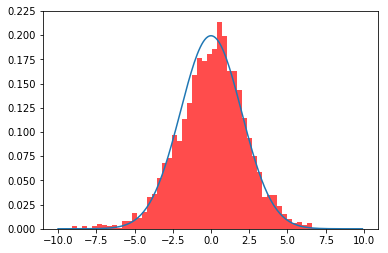

In [10]:
### totaly time 
T = 5000
sigma = 1
state = [0]
for t in range(1,T+1):
    ## current state
    xt = state[t-1]
    ## sample the next state 
    xt_next = norm.rvs(loc = xt, scale = sigma, size = 1)[0]
    ## calculate the accept factor, this is aproximate, assumeing the the Q is symmetric.
    temp = norm.pdf(xt_next, global_mean, global_sigma)/norm.pdf(xt, global_mean, global_sigma)
    ## add some modification
#     temp *= norm.pdf(xt, xt_next, sigma)/norm.pdf(xt_next, xt, sigma)
    alpha = min(1, temp)
    ## determine accept or not
    u = np.random.uniform()
    if u <= alpha:
        state.append(xt_next)
    else:
        state.append(xt)

plt.plot(raw, norm.pdf(raw, global_mean, global_sigma))
num_bins = 50
plt.hist(state, num_bins, normed=1, facecolor='red', alpha=0.7)
plt.show()

as can be seen in the above graph. 
<br>The sampled is in line with the desired distribution.<br>
May be we can try a little bit complicated distribution.

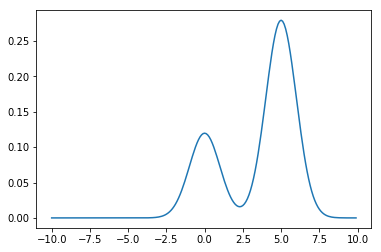

In [14]:
class Mix2Gaussian():
    def __init__(self,a1=0.5, a2=0.5, m1=0, s1=1, m2=5, s2=1):
        self.a1 = a1
        self.a2 = a2
#         self.m1 = m1
#         self.m2 = m2
#         self.s1 = s1
#         self.s2 = s2
        self.model1 = norm(m1,s1)
        self.model2 = norm(m2,s2)
    
    def pdf(self,x):
#         return self.a1*norm.pdf(x, self.m1, self.s1) + self.a2*norm.pdf(x, self.m2, self.s2)
        return self.a1*self.model1.pdf(x) + self.a2*self.model2.pdf(x)

        

raw = np.arange(-10,10, 0.1)
mixture = Mix2Gaussian(0.3,0.7)
plt.plot(raw, mixture.pdf(raw))

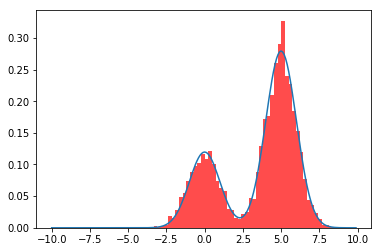

In [15]:
### totaly time 
T = 20000
sigma = 8
state = [0]
for t in range(1,T+1):
    ## current state
    xt = state[t-1]
    ## sample the next state 
    xt_next = norm.rvs(loc = xt, scale = sigma, size = 1)[0]
    ## calculate the accept factor, this is aproximate, assumeing the the Q is symmetric.
    temp = mixture.pdf(xt_next)/mixture.pdf(xt)
    ## add some modification
#     temp *= norm.pdf(xt, xt_next, sigma)/norm.pdf(xt_next, xt, sigma)
    alpha = min(1, temp)
    ## determine accept or not
    u = np.random.uniform()
    if u <= alpha:
        state.append(xt_next)
    else:
        state.append(xt)

plt.plot(raw, mixture.pdf(raw))
num_bins = 50
plt.hist(state, num_bins, normed=1, facecolor='red', alpha=0.7)
plt.show()

seems good.

## Gibbs Sampling 

Notive that Gibss sampling only work when the  **dimension of data >= 2** 

In [70]:
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import multivariate_normal
from matplotlib import cm
import math

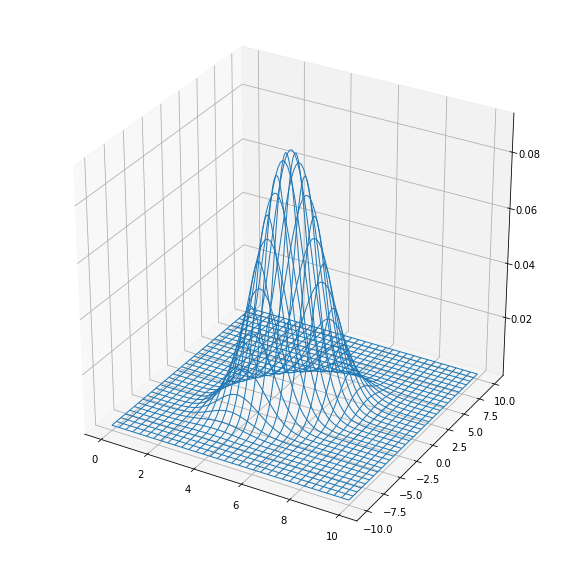

In [61]:
two_normal = multivariate_normal([5, -1], [[1,1],[1,4]])

size = 100
x = np.linspace(0, 10, size)
y = np.linspace(-10, 10, size)
x,y = np.meshgrid(x,y)

pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x
pos[:, :, 1] = y

z = two_normal.pdf(pos)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe(x, y, z, rstride=3, cstride=3, linewidth=1, antialiased=True,
                cmap=cm.viridis)


plt.show()

In [83]:
z = two_normal.pdf([0,0])

now we try to sample this 

In the following code, we will use this kind of thought

outer loop is for per sample

inner loop is after K markov, we take one sample

In [98]:
T = 5000
K = 200

### final sample
x_state = []
y_state = []

### for 3d plot
z_state = []



rho = 0.5
m1 = 5
m2 = -1
s1 = 1
s2 = 2
y = 0

def p_ygivenx(x, m1=m1, m2=m2, s1=s1, s2=s2):
    return norm.rvs(m2 + rho * s2 / s1 * (x - m1), math.sqrt(1 - rho ** 2) * s2)

def p_xgiveny(y, m1, m2, s1, s2):
    return norm.rvs(m1 + rho * s1 / s2 * (y - m2), math.sqrt(1 - rho ** 2) * s1)

for t in range(T):
    for k in range(K):
        ### p(x|y) 
        x = p_xgiveny(y, m1, m2, s1, s2)
        y = p_ygivenx(x, m1, m2, s1, s2)
    z = two_normal.pdf([x,y])
    x_state.append(x)
    y_state.append(y)
    z_state.append(z)
        

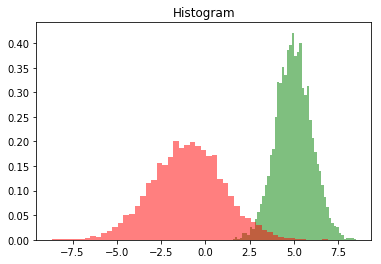

In [99]:
num_bins = 50
plt.hist(x_state, num_bins, normed=1, facecolor='green', alpha=0.5)
plt.hist(y_state, num_bins, normed=1, facecolor='red', alpha=0.5)
plt.title('Histogram')
plt.show()

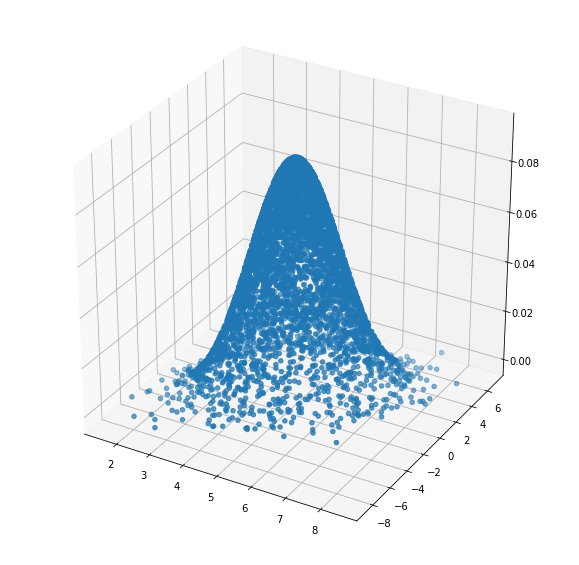

In [101]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_state, y_state, z_state,marker='o')
plt.show()